In [82]:
import cv2
import math
import torch
import numpy as np
import sympy
from sympy import Line, Point
from matplotlib import pyplot as plt
from operator import itemgetter

In [83]:
def hough_line(img, thetas):
    w, h = img.shape
    
    diag_len = int(round(math.sqrt(w * w + h * h)))
    rhos = np.linspace(0, diag_len, diag_len)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype = "uint64")

    # Cache some resuable values
    num_thetas = len(thetas)
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
 
    for y in range(0, h):
        for x in range(0, w):
            for theta_ind in range(0, len(thetas)):
                theta = thetas[theta_ind]
                rho = int(abs(round(x * sin_t[theta_ind] + y * cos_t[theta_ind])))
                accumulator[rho, theta_ind] += img[x, y]
    return accumulator, rhos, thetas

def get_hough_lines(accumulator, rhos, thetas, n):
    lines = []
    w, h = accumulator.shape
    for rho_ind in range(0, w):
        for theta_ind in range(0, h):
            lines.append((rhos[rho_ind], thetas[theta_ind], accumulator[rho_ind, theta_ind]))
    
    lines = sorted(lines, key=itemgetter(2), reverse=True)
    return lines[:n]

def show_hough_line(img, accumulator, rhos, thetas):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')
    
    plt.show()

In [84]:
def get_houth_line_v(lines):
    lines_v = []
    for line in lines:
        for rho,theta in line: 
            if theta < math.pi / 6 or theta > math.pi * 5 / 6:
                lines_v.append([(rho, theta)])
    return lines_v
            
def get_houth_line_h(lines):
    lines_h = []
    for line in lines:
        for rho,theta in line:
            if theta > math.pi * 2 / 6 and theta < math.pi * 4 / 6:
                lines_h.append([(rho, theta)]) 
    return lines_h

def get_external_quad(points):
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    for x, y in points:
        if (x > max_x):
            max_x = x
        if (y > max_y):
            max_y = y
        if (x < min_x):
            min_x = x
        if (y < min_y):
            min_y = y
    a = (min_x, min_y)  
    b = (max_x, min_y)
    c = (max_x, max_y)
    d = (min_x, max_y)
    return [a, b, c, d]

def get_np_array_from_points(points):
    arr = []
    for x, y in points:
        arr.append([x, y])
    return np.array(arr, dtype = "float32")

def reorder_points(points):
    c = np.array([0, 0], dtype = "float32")
    
    for x, y in points:
        c = c + np.array([x, y], dtype = "float32")
    dev = len(points)
    c = c / dev
    
    arr = []
    for x, y in points:
        vect = np.array([x, y]) - np.array([c[0], c[1]])
        arr.append(((x, y), math.atan2(vect[0], vect[1])))
    arr = sorted(arr, key=itemgetter(1))
    
    new_points = []
    for p, score in arr:
        new_points.append(p)
        
    return new_points

def Hough2Segm(line, wing = 256):
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + wing*(-b))
        y1 = int(y0 + wing*(a))
        x2 = int(x0 - wing*(-b))
        y2 = int(y0 - wing*(a))
        l = [(x1,y1), (x2, y2)]
    return l

def Hough2CVLine(line, wing = 256):
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + wing*(-b))
        y1 = int(y0 + wing*(a))
        x2 = int(x0 - wing*(-b))
        y2 = int(y0 - wing*(a))
        l = Line(Point(x1,y1), Point(x2, y2))
        return l

def draw_Hough_lines(lines, img, col, w = 2):
    wing = 256
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + wing*(-b))
            y1 = int(y0 + wing*(a))
            x2 = int(x0 - wing*(-b))
            y2 = int(y0 - wing*(a))
            cv2.line(img,(x1,y1),(x2,y2), col,w)

In [85]:
# def get_quad(img, log_img):
#     tmp = img.copy()
#     shape = img.shape
#     quad = [Point(0, 0), Point(0, shape[1]), Point(shape[0], shape[1]), Point(shape[0], 0)]
    
#     thetas = np.deg2rad(np.arange(-90.0, 90.0, 1))
#     accumulator, rhos, thetas = hough_line(img, thetas)
#     show_hough_line(img, accumulator, rhos, thetas)
    
#     lines = get_hough_lines(accumulator, rhos, thetas, 32)
#     print(lines)
    
#     lines_v = []
#     lines_h = []
#     for line in lines:
#         print(line)
#         rho,theta,score = line
#         if theta < math.pi / 6 or theta > math.pi * 5 / 6:
#             lines_v.append([(rho, theta)])
#         if theta > math.pi * 2 / 6 and theta < math.pi * 4 / 6:
#             lines_h.append([(rho, theta)])  

#     draw_Hough_lines(lines_h, log_img, (255))
#     draw_Hough_lines(lines_v, log_img, (255))
    
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(log_img)

#     if (len(lines_h) < 2 or len(lines_v) < 2):
#         return quad
    
#     arr = []
#     for line_v in lines_v:
#         for rho,theta in line_v:
#             arr.append((line_v, rho * np.cos(theta)))    
#     arr = sorted(arr, key=itemgetter(1))
#     line0 = Hough2CVLine(arr[0][0])
#     line2 = Hough2CVLine(arr[len(arr) - 1][0])
    
#     arr = []            
#     for line_h in lines_h:
#         for rho,theta in line_h:
#             arr.append((line_h, rho * np.sin(theta)))    
#     arr = sorted(arr, key=itemgetter(1))
#     line1 = Hough2CVLine(arr[0][0])
#     line3 = Hough2CVLine(arr[len(arr) - 1][0])
                            
#     a = line0.intersection(line1) 
#     if  not a or not isinstance(a[0], Point):
#         return quad
                    
#     b = line1.intersection(line2)
#     if  not b or not isinstance(b[0], Point):
#         return quad
    
                    
#     c = line2.intersection(line3)
#     if  not c or not isinstance(c[0], Point):
#         return quad
                    
#     d = line3.intersection(line0)
#     if  not d or not isinstance(d[0], Point):
#         return quad
    
#     quad = [a[0], b[0], c[0], d[0]]
    
#     return quad
#     thetas = np.deg2rad(np.arange(-45.0, 45.0, 1))
#     accumulator, rhos, thetas = hough_line(edges, thetas)
#     show_hough_line(edges, accumulator, rhos, thetas)
#     lines_h = get_hough_line(accumulator, rhos, thetas, 128)
    
#     thetas = np.deg2rad(np.arange(-90.0, -45.0, 1) + np.arange(45.0, 90.0, 1))
#     accumulator, rhos, thetas = hough_line(edges, thetas)
#     show_hough_line(edges, accumulator, rhos, thetas)
#     lines_h = get_hough_line(accumulator, rhos, thetas, 128)

In [86]:
def get_quad(img, log_img):
    
    tmp = img.copy()
    w, h = img.shape
    quad = [(0, 0), (h, 0),(h, w), (0, w)]
    
    center = (int(w/2), int(h/2))
    #
    zone = img[:center[0],:]
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(zone)
    
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(w / 3))
    if lines is None:
        return quad
    lines = get_houth_line_h(lines)
    if len(lines) == 0:
        return quad
    line0 = Hough2CVLine(lines[0])
    #                      
    zone = img[center[0]:,]
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(zone)
    
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(w / 3))
    if lines is None:
        return quad
    lines = get_houth_line_h(lines)
    if len(lines) == 0:
        return quad
    line2 = Hough2CVLine(lines[0])
    p1 = Point(0, center[0]) + line2.p1
    p2 = Point(0, center[0]) + line2.p2
    line2 = Line(p1, p2)
    #
    zone = img[:,:center[1]]
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(zone)
    
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(h / 3))
    if lines is None:
        return quad
    lines = get_houth_line_v(lines)
    if len(lines) == 0:
        return quad
    line1 = Hough2CVLine(lines[0])
    #
    zone = img[:,center[1]:]
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(zone)
    
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(h / 3))
    if lines is None:
        return quad
    lines = get_houth_line_v(lines)
    if len(lines) == 0:
        return quad
    line3 = Hough2CVLine(lines[0])
    p1 = Point(center[1], 0) + line3.p1
    p2 = Point(center[1], 0) + line3.p2
    line3 = Line(p1, p2)
    
    #                        
    a = line0.intersection(line1) 
    if  not a or not isinstance(a[0], Point):
        return quad
                    
    b = line1.intersection(line2)
    if  not b or not isinstance(b[0], Point):
        return quad
                   
    c = line2.intersection(line3)
    if  not c or not isinstance(c[0], Point):
        return quad
                    
    d = line3.intersection(line0)
    if  not d or not isinstance(d[0], Point):
        return quad
    
    quad = [(a[0].x, a[0].y), (b[0].x, b[0].y), (c[0].x, c[0].y), (d[0].x, d[0].y)]
    
    return quad

In [87]:
# def get_quad(img, log_img):
    
#     tmp = img.copy()
#     w, h = img.shape
#     quad = [(0, 0), (h, 0),(h, w), (0, w)]
    
    
#     lines_v = cv2.HoughLines(img, 1, np.pi/360, int(h / 2))
#     if lines_v is None:
#         lines_v = []
                             
#     lines = []
#     for line in lines_v:
#         for rho,theta in line:
#             if theta < math.pi / 6 or theta > math.pi * 5 / 6:
#                 lines.append(line)
#     lines_v = lines  
#     draw_Hough_lines(lines_v, log_img, (255))

#     lines_h = cv2.HoughLines(img, 1, np.pi/360, int(w / ))
#     if lines_h is None:
#         lines_h = []
                             
#     lines = []
#     for line in lines_h:
#         for rho,theta in line:
#             if theta > math.pi * 2 / 6 and theta < math.pi * 4 / 6:
#                 lines.append(line)           
#     lines_h = lines
#     draw_Hough_lines(lines_h, log_img, (255))
    
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(log_img)

#     if (len(lines_h) < 2 or len(lines_v) < 2):
#         return quad
    
#     arr = []
#     for line_v in lines_v:
#         for rho,theta in line_v:
#             arr.append((line_v, rho * np.cos(theta)))    
#     arr = sorted(arr, key=itemgetter(1))
    
#     line0 = Hough2CVLine(arr[0][0])
#     line2 = Hough2CVLine(arr[len(arr) - 1][0])
    
#     arr = []            
#     for line_h in lines_h:
#         for rho,theta in line_h:
#             arr.append((line_h, rho * np.sin(theta)))    
#     arr = sorted(arr, key=itemgetter(1))
    
#     line1 = Hough2CVLine(arr[0][0])
#     line3 = Hough2CVLine(arr[len(arr) - 1][0])
                            
#     a = line0.intersection(line1) 
#     if  not a or not isinstance(a[0], Point):
#         return quad
                    
#     b = line1.intersection(line2)
#     if  not b or not isinstance(b[0], Point):
#         return quad
                   
#     c = line2.intersection(line3)
#     if  not c or not isinstance(c[0], Point):
#         return quad
                    
#     d = line3.intersection(line0)
#     if  not d or not isinstance(d[0], Point):
#         return quad
    
#     quad = [(a[0].x, a[0].y), (b[0].x, b[0].y), (c[0].x, c[0].y), (d[0].x, d[0].y)]
    
#     return quad

In [88]:
def get_map_zone(img):
    tmp = img.copy()
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(tmp)

    diag = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
    n = int(diag / 100) * 2 + 1
    shape = img.shape

    edges = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.normalize(edges,  edges, 0, 255, cv2.NORM_MINMAX)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)

    edges = cv2.GaussianBlur(edges,(3, 3), 0)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)

#     edges = cv2.adaptiveThreshold(edges,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv2.THRESH_BINARY,n,2)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)


    edges = cv2.Laplacian(edges,cv2.CV_8UC1)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)
    
#     ret,edges = cv2.threshold(edges,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.adaptiveThreshold(edges,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,n,-2)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)
    
#     edges = cv2.Canny(edges,32,64)
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(edges)

    quad = get_quad(edges, tmp)
    
    quad = reorder_points(quad)

    a = (int(quad[0][0]), int(quad[0][1])) 
    b = (int(quad[1][0]), int(quad[1][1]))
    cv2.line(tmp,a,b,(255,0,0),4)
    a = quad[2]
    b = quad[1]
    cv2.line(tmp,a,b,(255,0,0),4)
    a = quad[2]
    b = quad[3]
    cv2.line(tmp,a,b,(255,0,0),4)
    a = quad[0]
    b = quad[3]
    cv2.line(tmp,a,b,(255,0,0),4)

#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(tmp)

    src_quad = get_np_array_from_points(quad)
    
    new_h = int((src_quad[1][1] - src_quad[0][1] + src_quad[2][1] - src_quad[3][1]) / 2)
    new_w = int((src_quad[3][0] - src_quad[0][0] + src_quad[2][0] - src_quad[1][0]) / 2)
       
    dst = [(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)]
    dst = reorder_points(dst)
    dst_quad = get_np_array_from_points(dst)
       
    M = cv2.getPerspectiveTransform(src_quad, dst_quad)
    warped = cv2.warpPerspective(img, M, (new_w, new_h))
#     plt.figure(figsize=(19.4, 12.9))
#     plt.imshow(warped)
    
    return warped

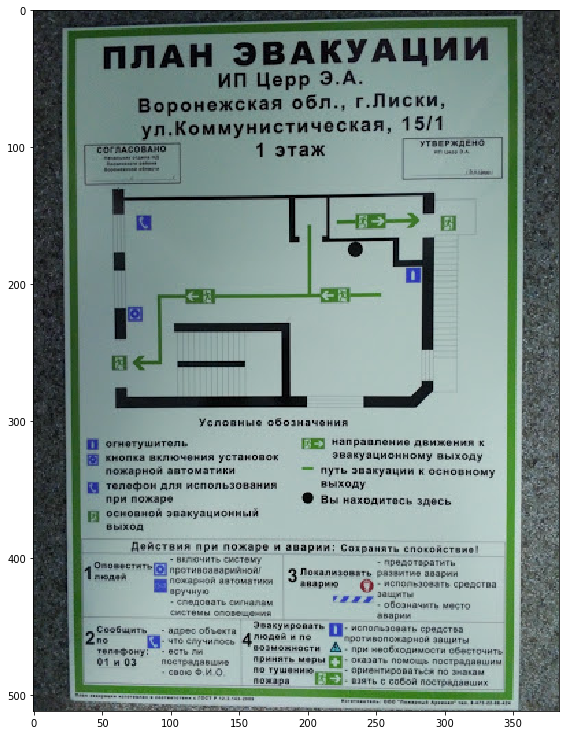

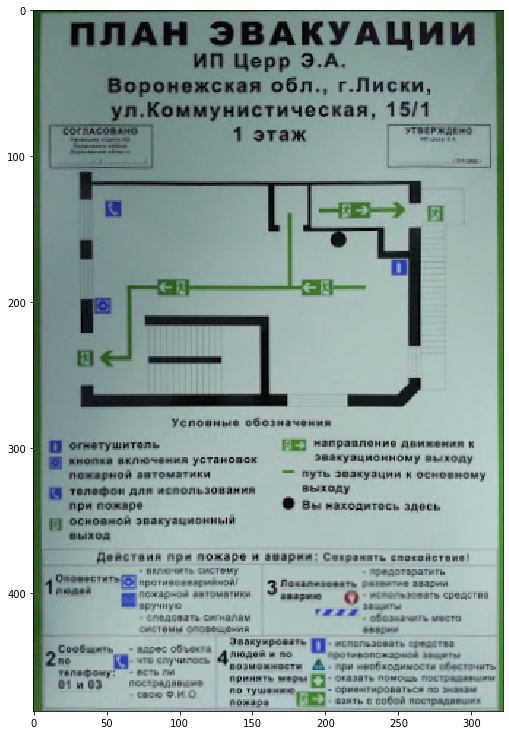

In [108]:
img = cv2.imread('photo/19.jpg')
plt.figure(figsize=(19.4, 12.9))
plt.imshow(img)

warped = get_map_zone(img)
plt.figure(figsize=(19.4, 12.9))
plt.imshow(warped)